In [1]:
#General imports.
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)
import matplotlib.pyplot as plt
import csv
import pandas

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import os
import scipy

import uproot # https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf
from awkward import JaggedArray
from root_pandas import read_root # https://github.com/scikit-hep/root_pandas

import warnings
warnings.filterwarnings('once')

%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.
Welcome to JupyROOT 6.12/06


In [2]:
f = r.TFile("./data/energy_time_60hr_most.root")
f.ls()

TFile**		./data/energy_time_60hr_most.root	
 TFile*		./data/energy_time_60hr_most.root	
  KEY: TCanvas	c1;1	c1


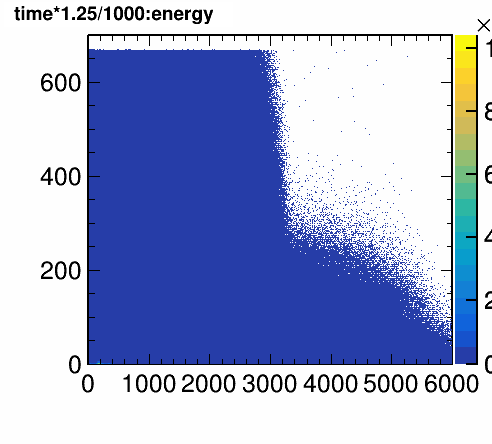

In [3]:
c1 = f.Get("c1")
c1.Draw()

In [4]:
h = c1.GetPrimitive("hist").Clone()
h.SetDirectory(0)
print(h)

<ROOT.TH2F object ("hist") at 0x7fffd79eb7e0>


In [5]:
c1.GetListOfPrimitives().Print()

Collection name='TList', class='TList', size=3
 TFrame  X1=0.000000 Y1=0.000000 X2=6000.000000 Y2=700.000000 Width=2 FillColor=10 FillStyle=1001
 TH1.Print Name  = hist, Entries= -2147483648, Total sum= 7.90641e+09
 TPaveText  X1=-1378.378419 Y1=718.037107 X2=2396.469016 Y2=770.945948 Width=2 FillStyle=1001
 Collection name='TList', class='TList', size=1
  Text  X=0.000000 Y=0.000000 Text=time*1.25/1000:energy Font=0 Size=0.000000 Color=0 Align=0


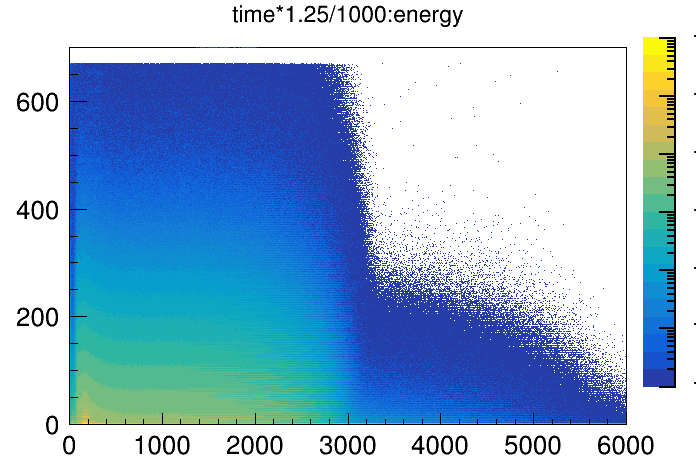

In [6]:
c2 = r.TCanvas()
h.Draw("COLZ")
c2.SetLogz()
c2.Draw()

f = r.TFile("./data/gm2offline_ana.root")
f.cd("farline/calo1")
#f.ls()

c = r.TCanvas()
evt = f.Get("farline").Get("calo1").Get("energy_vs_time").Clone()
for calo in range(2,25):
    evt2 = f.Get("farline").Get("calo"+str(calo)).Get("energy_vs_time").Clone()
    evt.Add(evt2,1)
evt.Draw("colz")
c.SetLogz()
c.Draw()

evt.Reset()
evt.Add(h,1)

In [7]:
evt = h.Clone()

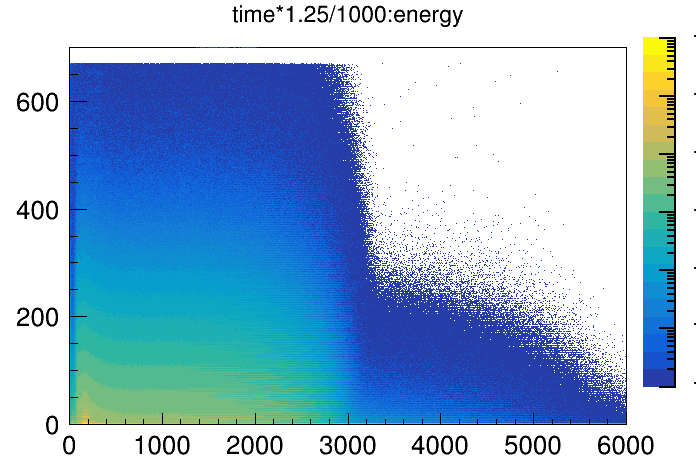

In [8]:
c2 = r.TCanvas()
evt.Draw("COLZ")
c2.SetLogz()
c2.Draw()

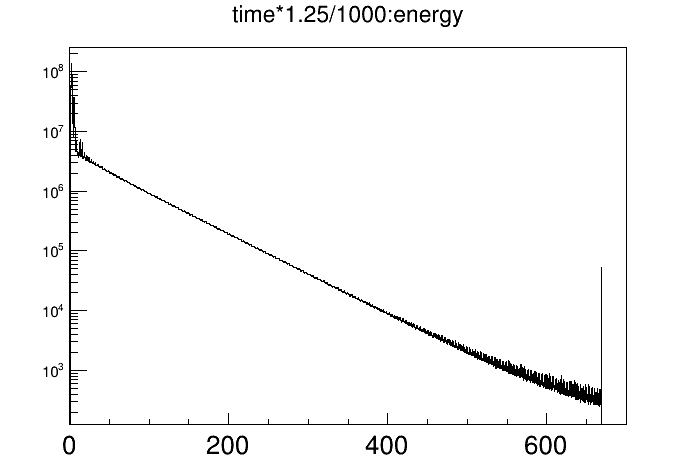

In [9]:
c2 = r.TCanvas()
evt.GetXaxis().SetRangeUser(0,700)
evt_time = evt.ProjectionY().Clone()
evt_time.Draw("COLZ")
c2.SetLogy()
c2.Draw()

In [10]:
timeBinWidth = evt_time.GetBinWidth(100)
timeBinCenters = []
for i in range(evt_time.GetNbinsX()):
    binCenter = evt_time.GetBinCenter(i)
    if(binCenter > 30 and binCenter < 600):
        timeBinCenters.append(binCenter)

In [11]:
timeBinCenters[:10]

[30.010638297872337,
 30.159574468085104,
 30.30851063829787,
 30.457446808510635,
 30.606382978723403,
 30.755319148936167,
 30.904255319148934,
 31.0531914893617,
 31.202127659574465,
 31.351063829787233]

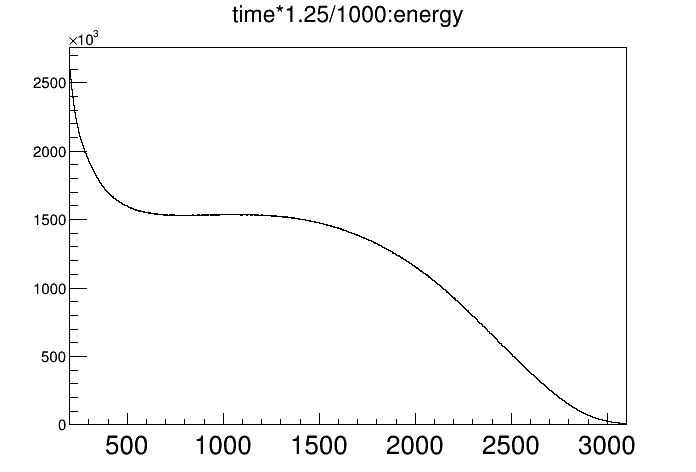

In [12]:
c2 = r.TCanvas()
e1 = 200 #200 and 3100 produced a stable result in the visualizer
e2 = 3100
t1 = 30
t2 = 600
evt.GetXaxis().SetRangeUser(e1,e2)
evt.GetYaxis().SetRangeUser(30,600)

cuti = r.TCutG("cuti")
cuti.SetPoint(0,e1,t1)
cuti.SetPoint(1,e2,t1)
cuti.SetPoint(2,e2,t2)
cuti.SetPoint(3,e1,t2)
cuti.SetPoint(4,e1,t1)

h = evt.ProjectionX("h",0,-1,"[cuti]").Clone()
#h.Scale(1/(h.GetEntries()))
h.Draw()
c2.Draw()

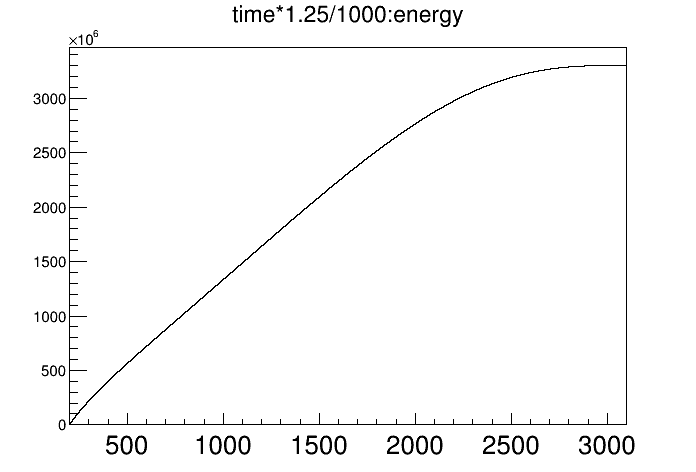

In [13]:
hcum = h.GetCumulative()
c2 = r.TCanvas()
hcum.Draw()
c2.Draw()

In [14]:
hscaled = h.Clone("hscaled")
hscaled.Scale(1/(hscaled.GetEntries()))

In [43]:
ndivs = len(timeBinCenters)
print(ndivs)
timeSlices1 = []
timeSlicesCum1 = []
times1 = []
timeSlices2 = []
timeSlicesCum2 = []
times2 = []

ks1 = []
ks2 = []

times = []
ks = []

for div in range(ndivs):
    t1 = timeBinCenters[div] - timeBinWidth
    t2 = timeBinCenters[div] + timeBinWidth
    evt.GetYaxis().SetRangeUser(t1,t2)
    
    cuti = r.TCutG("cuti")
    cuti.SetPoint(0,e1,t1)
    cuti.SetPoint(1,e2,t1)
    cuti.SetPoint(2,e2,t2)
    cuti.SetPoint(3,e1,t2)
    cuti.SetPoint(4,e1,t1)

    htemp = evt.ProjectionX("htemp",0,-1,"[cuti]").Clone()
    htemp.SetTitle("EvT Projection from Time Slice "+str(t1).zfill(3)+" - "+str(t2).zfill(3))
    #htemp.Scale(1/(htemp.GetEntries()))
    
    '''
    hprint = htemp.Clone("hprint")
    hprint.Scale(1/(hprint.GetEntries()))
    c = r.TCanvas("c","c",1000,1000)
    hscaled.Draw("HIST")
    hprint.SetLineColor(2)
    hprint.Draw("HIST SAME")
    hscaled.GetXaxis().SetRangeUser(0.0001,0.01)
    c.SetLogy()
    c.Draw()
    c.Print("./images/evt_"+str(div).zfill(5)+".png")
    '''
    
    hslice = htemp.GetCumulative()
    
    hscaledtemp = htemp.Clone()
    hscaledtemp.Scale(1/(htemp.GetEntries()))
    
    #print(hscaledtemp.GetBinContent(2000) , hscaled.GetBinContent(2000))
    
    if(hscaledtemp.GetBinContent(2000) > hscaled.GetBinContent(2000)):
        timeSlices1.append(htemp.Clone("h"+str(div+1)))
        timeSlicesCum1.append(htemp.GetCumulative().Clone("hcum"+str(div+1)))
        times1.append(t1)
        times.append(t1)
        ks1.append(hcum.KolmogorovTest(hslice,"M"))
        ks.append(hcum.KolmogorovTest(hslice,"M"))
    else:
        timeSlices2.append(htemp.Clone("h"+str(div+1)))
        timeSlicesCum2.append(htemp.GetCumulative().Clone("hcum"+str(div+1)))
        times2.append(t1)
        times.append(t1)
        ks2.append(hcum.KolmogorovTest(hslice,"M"))
        ks.append(hcum.KolmogorovTest(hslice,"M"))    

3828


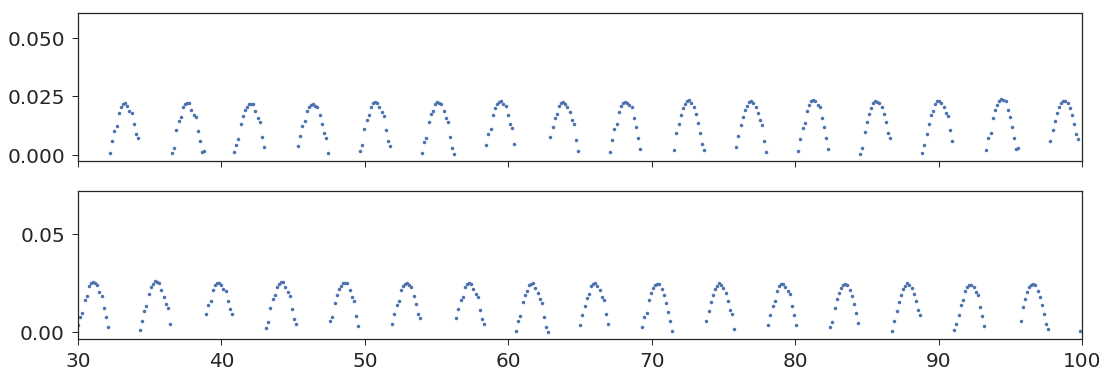

In [44]:
fig,ax = plt.subplots(2,1,figsize=(18,6),sharex=True)
ax[0].plot(times1, ks1,'.')
ax[1].plot(times2, ks2,'.')

plt.xlim(30,100)
plt.show()

In [45]:
from scipy import signal
sig = ks1
win = ks2
filtered = signal.convolve(sig, win, mode='same', method='direct') / sum(win)

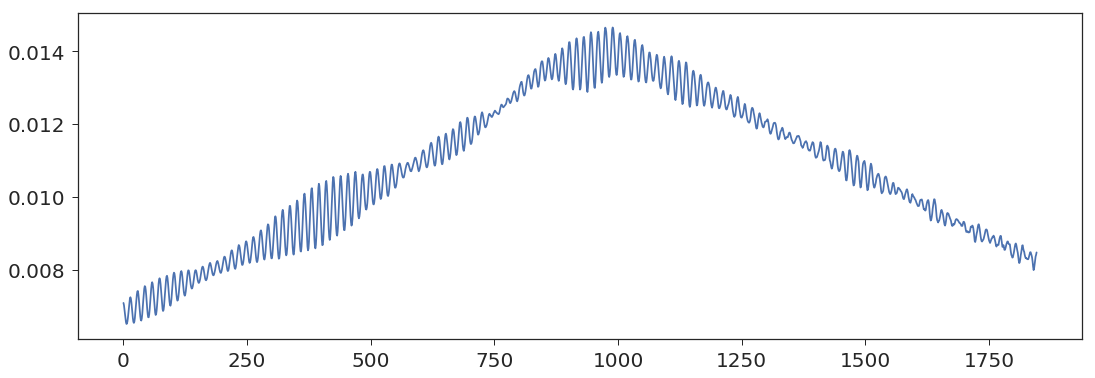

In [46]:
fig,ax = plt.subplots(figsize=(18,6))
plt.plot(filtered)
plt.show()

---

### Maybe we can try convolving two sets together?

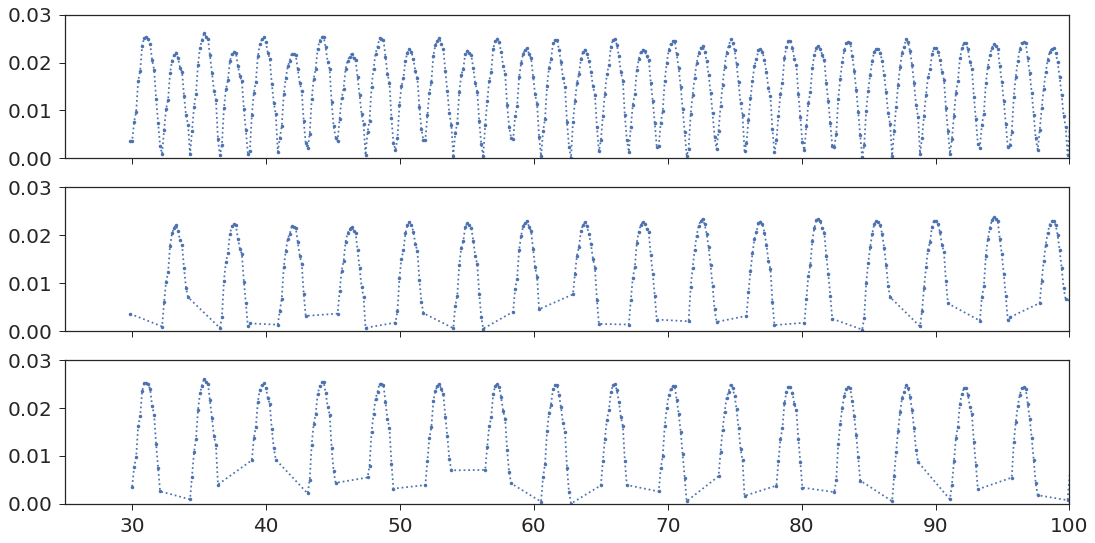

In [55]:
fig,ax = plt.subplots(3,1,figsize=(18,9),sharex=True, sharey=True)
ax[0].plot(times, ks,':.')
ax[1].plot(times1, ks1,':.')
ax[2].plot(times2, ks2,':.')

plt.xlim(25,100)
plt.ylim(0,0.03)
plt.show()

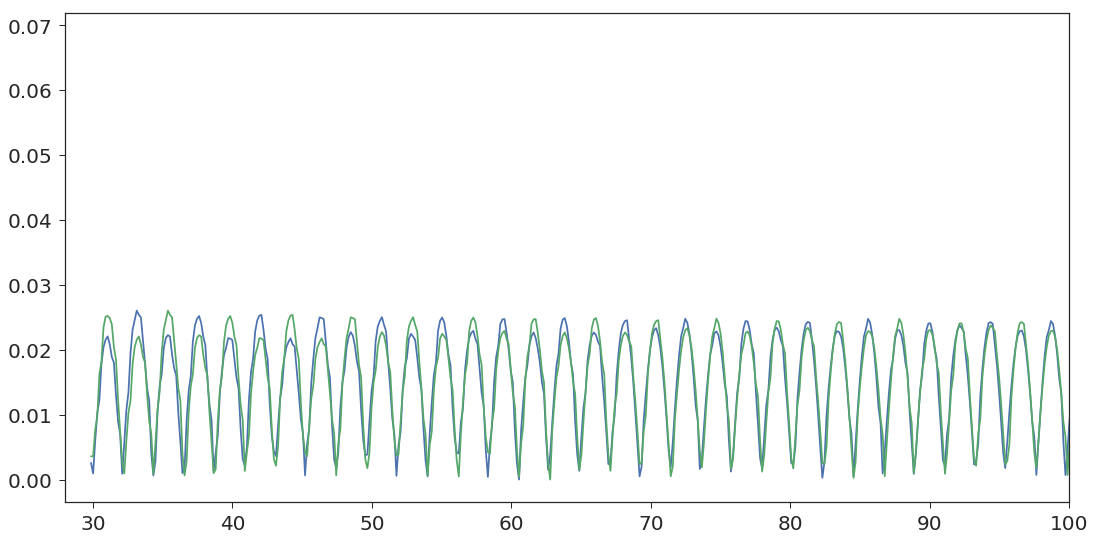

In [63]:
fig,ax = plt.subplots(figsize=(18,9))
shift = 15
ksshift = ks[shift:] + ks[:shift]
plt.plot(times, ksshift)
plt.plot(times, ks)
plt.xlim(28,100)
plt.show()

In [64]:
from scipy import signal
sig = ks
win = ksshift
filtered = signal.convolve(sig, win, mode='same', method='direct') / sum(win)

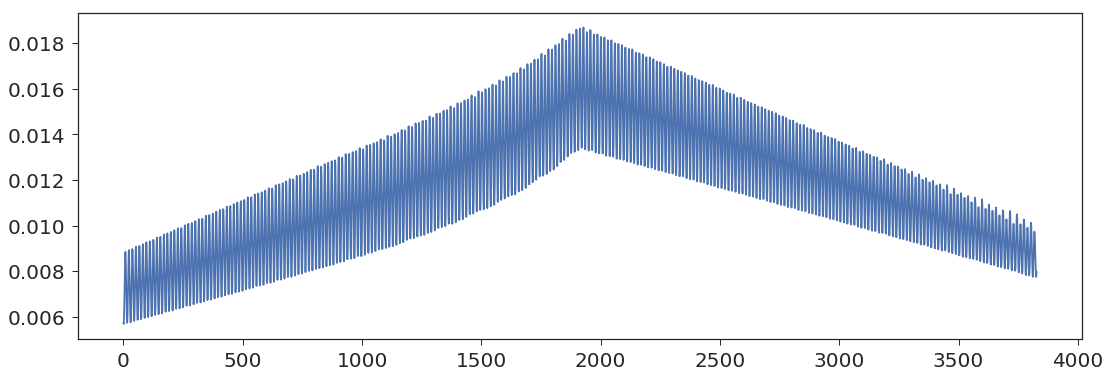

In [65]:
fig,ax = plt.subplots(figsize=(18,6))
plt.plot(filtered)
plt.show()

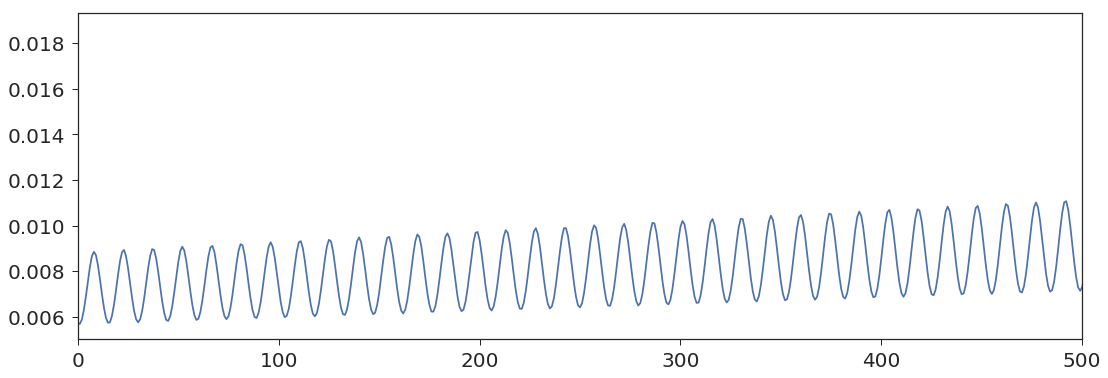

In [68]:
fig,ax = plt.subplots(figsize=(18,6))
plt.plot(filtered)
plt.xlim(0,500)
plt.show()